<a href="https://colab.research.google.com/github/KristinaBorovikS/ML/blob/main/HW6/hw6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

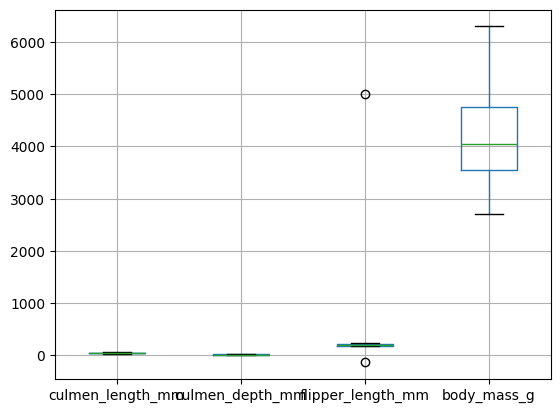

3


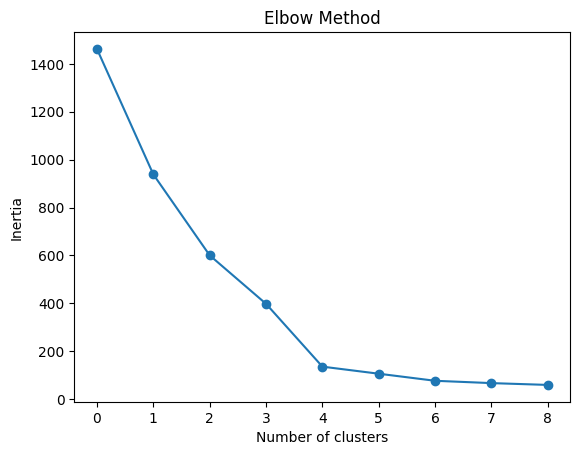

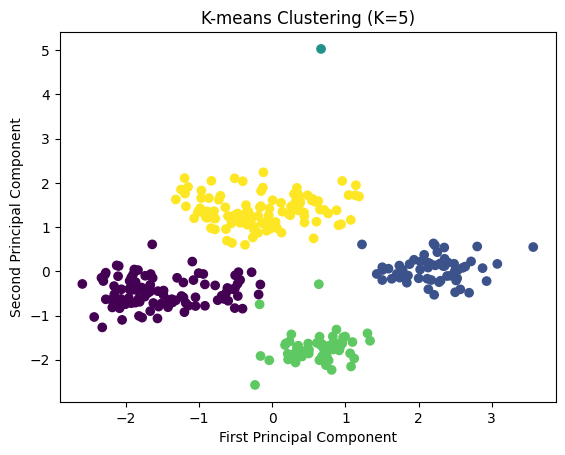

Number of clusters: 5,
 Silhouette Score: 0.65,
 Davies-Bouldin Index: 0.38,
 Inertia: 135.22,
 Calinski-Harabasz Index: 809.82
Average Silhouette Score: 0.65


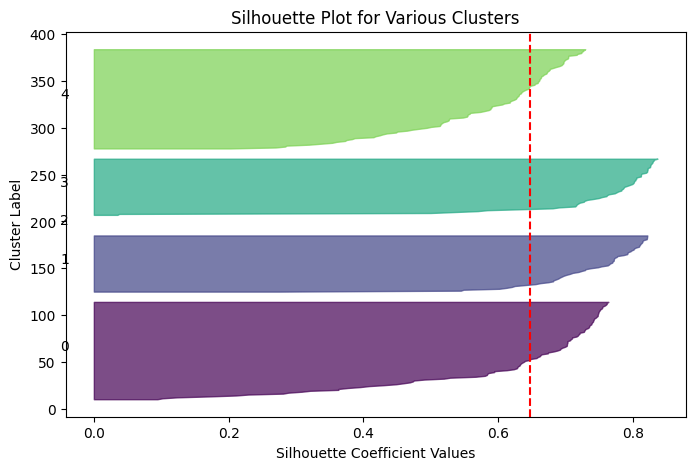

Epoch [1/100], Loss: 1.2508
Epoch [2/100], Loss: 1.2810
Epoch [3/100], Loss: 1.0395
Epoch [4/100], Loss: 0.7936
Epoch [5/100], Loss: 0.6431
Epoch [6/100], Loss: 0.7259
Epoch [7/100], Loss: 0.8034
Epoch [8/100], Loss: 0.7779
Epoch [9/100], Loss: 0.6456
Epoch [10/100], Loss: 0.6163
Epoch [11/100], Loss: 0.8093
Epoch [12/100], Loss: 0.5743
Epoch [13/100], Loss: 0.7043
Epoch [14/100], Loss: 0.7466
Epoch [15/100], Loss: 0.6072
Epoch [16/100], Loss: 0.3317
Epoch [17/100], Loss: 0.7318
Epoch [18/100], Loss: 0.4348
Epoch [19/100], Loss: 0.5669
Epoch [20/100], Loss: 0.5784
Epoch [21/100], Loss: 0.5538
Epoch [22/100], Loss: 0.7059
Epoch [23/100], Loss: 0.5544
Epoch [24/100], Loss: 0.5409
Epoch [25/100], Loss: 0.5156
Epoch [26/100], Loss: 0.6822
Epoch [27/100], Loss: 0.4927
Epoch [28/100], Loss: 0.2492
Epoch [29/100], Loss: 0.3645
Epoch [30/100], Loss: 0.3446
Epoch [31/100], Loss: 0.6169
Epoch [32/100], Loss: 0.5850
Epoch [33/100], Loss: 0.5821
Epoch [34/100], Loss: 0.3729
Epoch [35/100], Loss: 0

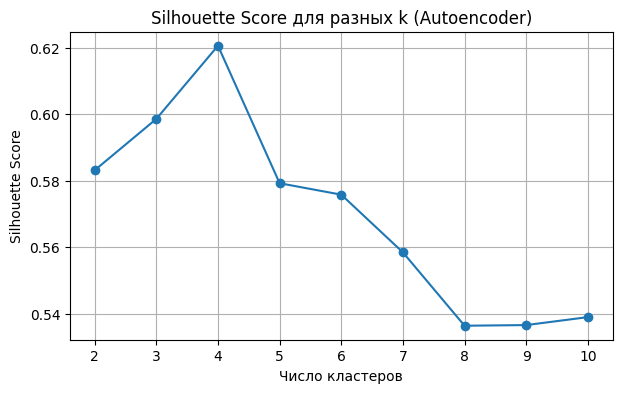

Number of clusters: 4,
 Silhouette Score: 0.62,
 Davies-Bouldin Index: 0.44,
 Inertia: 38.28,
 Calinski-Harabasz Index: 1734.98


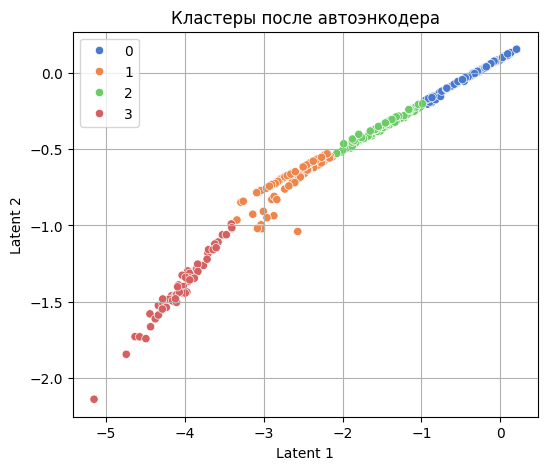

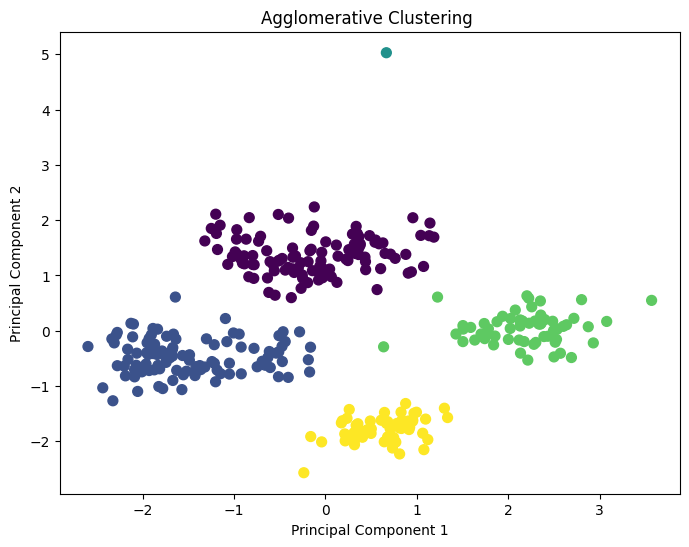

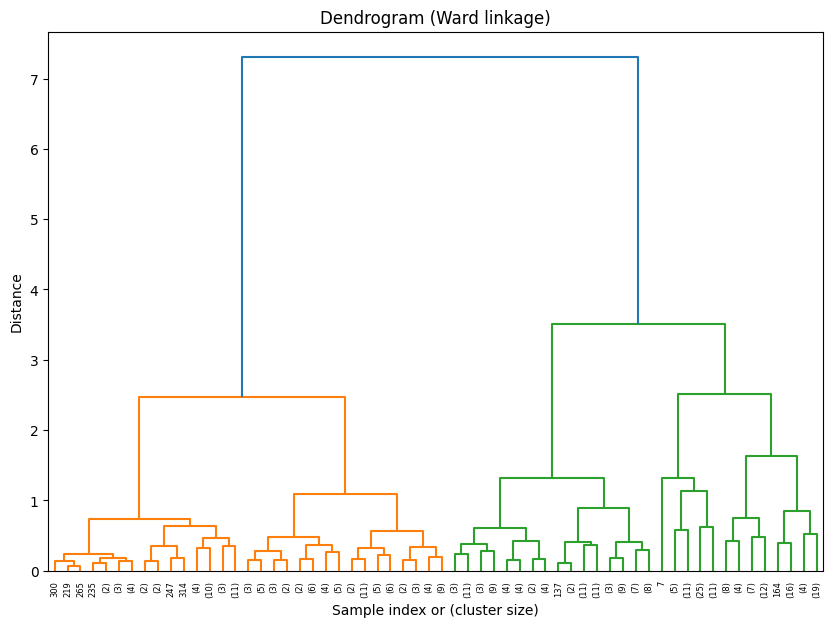

Силуэтовская оценка: 0.30
Индекс Дэвиса-Болдуина: 1.00
Индекс Калински-Харабаса: 202.20


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


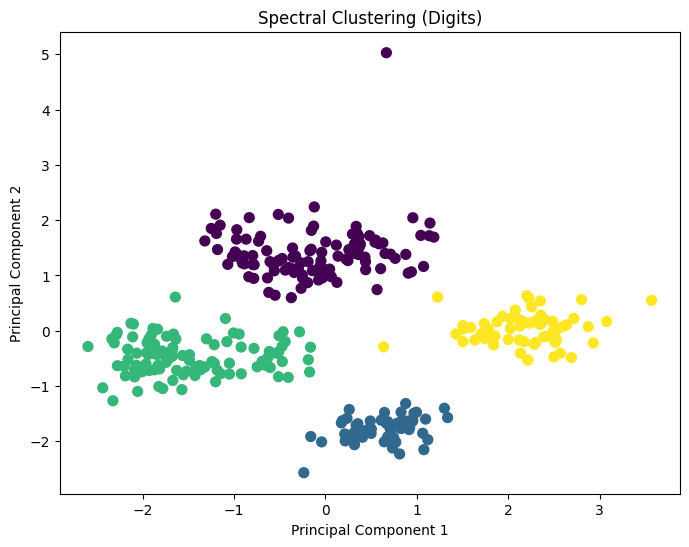

Силуэтовская оценка: 0.63
Индекс Дэвиса-Болдуина: 0.53
Индекс Калински-Харабаса: 234.84


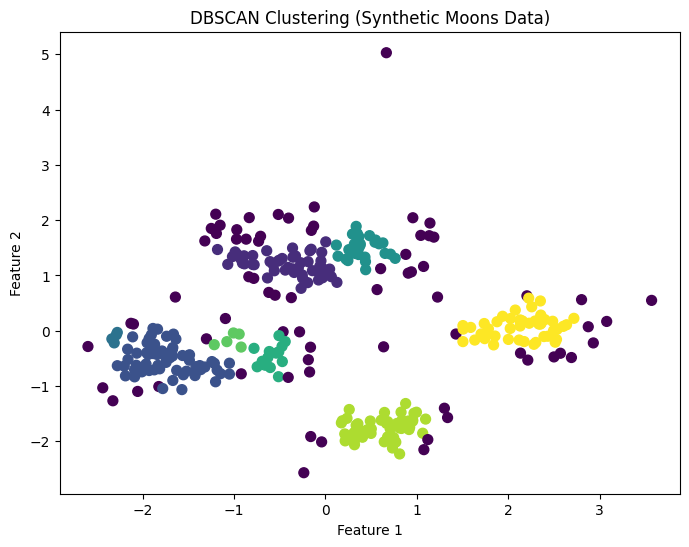

Силуэтовская оценка: 0.32
Индекс Дэвиса-Болдуина: 1.04
Индекс Калински-Харабаса: 247.74


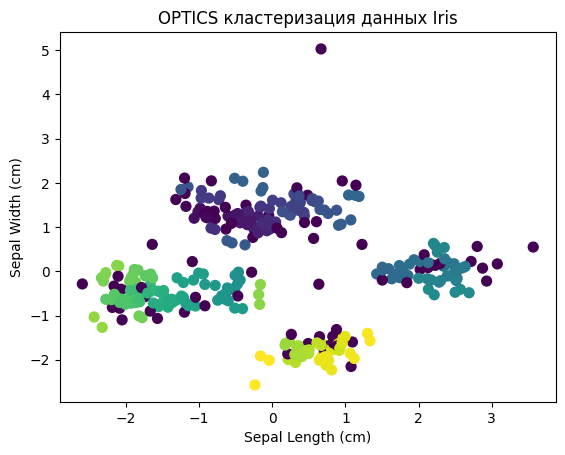

Силуэтовская оценка: 0.18
Индекс Дэвиса-Болдуина: 1.35
Индекс Калински-Харабаса: 3.80


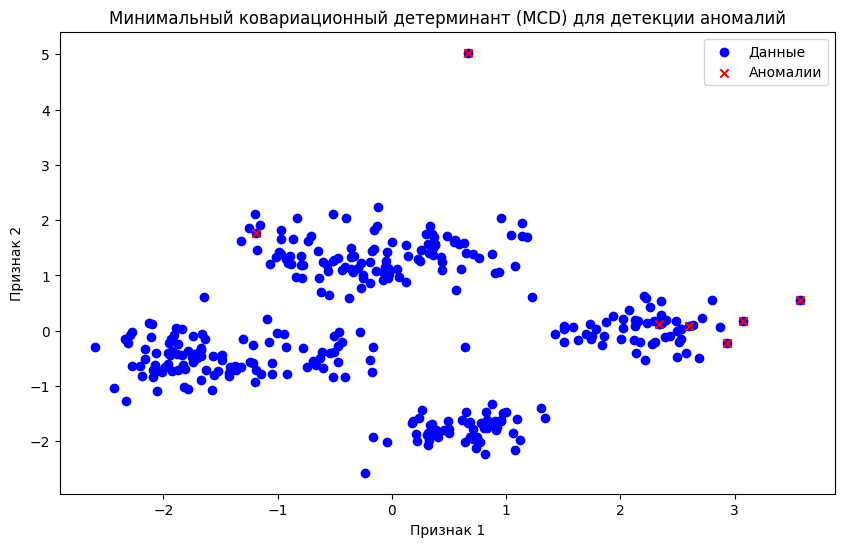

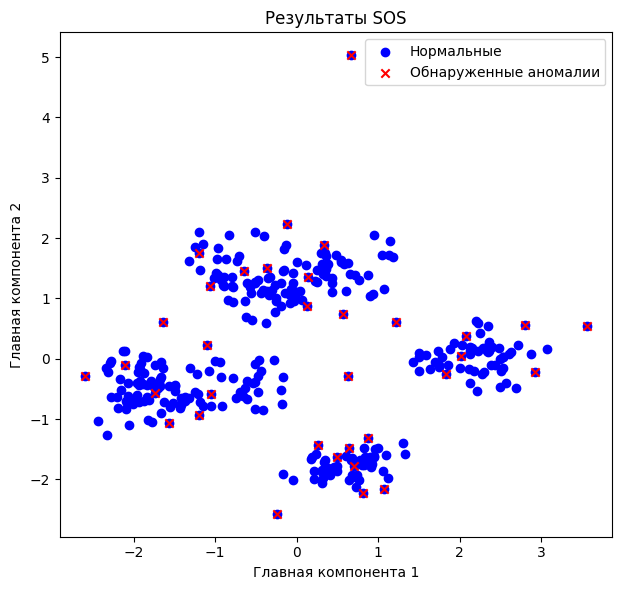

In [12]:



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial.distance import cdist
import warnings
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import silhouette_samples

warnings.filterwarnings("ignore", category=FutureWarning)
penguins_df = pd.read_csv("penguins.csv")
df_new = penguins_df.replace('', pd.NA)
penguins_df.head()
penguins_df.boxplot()
plt.show()
penguins_df = penguins_df.dropna()
penguins_df[penguins_df["flipper_length_mm"] > 4000]
penguins_df[penguins_df["flipper_length_mm"] < 0]
penguins_clean = penguins_df.drop([9, 14])
penguins_clean.head()
df=penguins_df

le = LabelEncoder()

df['sex']=le.fit_transform(df['sex'])
df.head()
scaler = StandardScaler()
X = scaler.fit_transform(df)
penguins_preprocessed = pd.DataFrame(data=X, columns=df.columns)
penguins_preprocessed.head(10)


pca = PCA(n_components=None)
dfx_pca = pca.fit(penguins_preprocessed)
dfx_pca.explained_variance_ratio_
n_components = sum(dfx_pca.explained_variance_ratio_ > 0.1)
pca = PCA(n_components=n_components)
penguins_PCA = pca.fit_transform(penguins_preprocessed)
print(n_components)
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(penguins_PCA)
    inertia.append(kmeans.inertia_)
plt.plot( inertia, marker="o")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(penguins_PCA)
y_kmeans = kmeans.predict(penguins_PCA)
plt.scatter(penguins_PCA[:, 0], penguins_PCA[:, 1], c=y_kmeans, cmap="viridis")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title(f"K-means Clustering (K={n_clusters})")
plt.show()

X=penguins_PCA
labels=y_kmeans
silhouette_scores = []
davies_bouldin_scores = []
inertia_scores = []
calinski_harabasz_scores = []

silhouette_avg = silhouette_score(X, labels)
davies_bouldin = davies_bouldin_score(X, labels)
inertia = kmeans.inertia_
calinski_harabasz = calinski_harabasz_score(X, labels)
print(f"Number of clusters: {n_clusters},\n Silhouette Score: {silhouette_avg:.2f},\n Davies-Bouldin Index: {davies_bouldin:.2f},\n Inertia: {inertia:.2f},\n Calinski-Harabasz Index: {calinski_harabasz:.2f}")

print(f"Average Silhouette Score: {silhouette_avg:.2f}")

sample_silhouette_values = silhouette_samples(X, labels)

plt.figure(figsize=(8, 5))
y_lower = 10
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.viridis(float(i) / n_clusters)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10

plt.title("Silhouette Plot for Various Clusters")
plt.xlabel("Silhouette Coefficient Values")
plt.ylabel("Cluster Label")
plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.show()








import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


df_new = df_new.dropna()

features = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
X_raw = df_new[features].values
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_raw)
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3, 3),
            nn.ReLU(),
            nn.Linear(3, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 3),
            nn.ReLU(),
            nn.Linear(3, 3)
        )
    def forward(self, x):
        z = self.encoder(x)

        return z, self.decoder(z)

X_tensor = torch.tensor(X, dtype=torch.float32)
loader = DataLoader(TensorDataset(X_tensor), batch_size=16, shuffle=True)
model = Autoencoder()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

for epoch in range(100):
    for batch in loader:
        x = batch[0]
        z, out = model(x)
        loss = loss_fn(out, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/100], Loss: {loss.item():.4f}')

with torch.no_grad():
    latent_features = model.encoder(X_tensor).numpy()


sil_scores = []

k_range = range(2, 11)
for k in k_range:
    labels = KMeans(n_clusters=k, random_state=42, n_init=10).fit_predict(latent_features)
    sil_scores.append(silhouette_score(latent_features, labels))

optimal_k = k_range[np.argmax(sil_scores)]
print(f"Оптимальное количество кластеров: {optimal_k}")

plt.figure(figsize=(7,4))
plt.plot(k_range, sil_scores, 'o-')
plt.xlabel('Число кластеров')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score для разных k (Autoencoder)')
plt.grid(True)
plt.show()

kmeans_ae = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels_ae = kmeans_ae.fit_predict(latent_features)

silhouette_avg = silhouette_score(latent_features, labels_ae)
davies_bouldin = davies_bouldin_score(latent_features, labels_ae)
inertia = kmeans_ae.inertia_
calinski_harabasz = calinski_harabasz_score(latent_features, labels_ae)
print(f"Number of clusters: {optimal_k},\n Silhouette Score: {silhouette_avg:.2f},\n Davies-Bouldin Index: {davies_bouldin:.2f},\n Inertia: {inertia:.2f},\n Calinski-Harabasz Index: {calinski_harabasz:.2f}")

plt.figure(figsize=(6, 5))
sns.scatterplot(x=latent_features[:, 0], y=latent_features[:, 1], hue=labels_ae, palette='muted')
plt.title("Кластеры после автоэнкодера")
plt.xlabel("Latent 1")
plt.ylabel("Latent 2")
plt.grid(True)
plt.legend()
plt.show()







import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage



n_clusters = 5
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
predicted_labels = agg_clustering.fit_predict(penguins_PCA)




plt.figure(figsize=(8, 6))
plt.scatter(penguins_PCA[:, 0], penguins_PCA[:, 1], c=predicted_labels, s=50, cmap='viridis')
plt.title("Agglomerative Clustering ")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


plt.figure(figsize=(10, 7))
Z = linkage(X_scaled, method='ward')
dendrogram(Z, truncate_mode='level', p=5)
plt.title('Dendrogram ')
plt.xlabel('Sample index or (cluster size)')
plt.ylabel('Distance')
plt.show()


silhouette_avg = silhouette_score(X_scaled, predicted_labels)
davies_bouldin = davies_bouldin_score(X_scaled, predicted_labels)
calinski_harabasz = calinski_harabasz_score(X_scaled, predicted_labels)

print(f"Силуэтовская оценка: {silhouette_avg:.2f}")
print(f"Индекс Дэвиса-Болдуина: {davies_bouldin:.2f}")
print(f"Индекс Калински-Харабаса: {calinski_harabasz:.2f}")





import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.cluster import MeanShift, estimate_bandwidth, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score


n_clusters = 4
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
predicted_labels = spectral.fit_predict(penguins_PCA)



plt.figure(figsize=(8, 6))
plt.scatter(penguins_PCA[:, 0],penguins_PCA[:, 1], c=predicted_labels, s=50, cmap='viridis')
plt.title("Spectral Clustering ")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

largest_cluster_label = np.argmax(np.bincount(predicted_labels))


silhouette_avg = silhouette_score(penguins_PCA, predicted_labels)
davies_bouldin = davies_bouldin_score(penguins_PCA, predicted_labels)
calinski_harabasz = calinski_harabasz_score(penguins_PCA, predicted_labels)

print(f"Силуэтовская оценка: {silhouette_avg:.2f}")
print(f"Индекс Дэвиса-Болдуина: {davies_bouldin:.2f}")
print(f"Индекс Калински-Харабаса: {calinski_harabasz:.2f}")



import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score


dbscan = DBSCAN(eps=0.2, min_samples=5) #
predicted_labels = dbscan.fit_predict(penguins_PCA)


plt.figure(figsize=(8, 6))
plt.scatter(penguins_PCA[:, 0], penguins_PCA[:, 1], c=predicted_labels, cmap='viridis', s=50)
plt.title("DBSCAN Clustering ")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

mask = predicted_labels != -1
silhouette_avg = silhouette_score(X_scaled[mask], predicted_labels[mask])
davies_bouldin = davies_bouldin_score(X_scaled[mask], predicted_labels[mask])
calinski_harabasz = calinski_harabasz_score(X_scaled[mask], predicted_labels[mask])

print(f"Силуэтовская оценка: {silhouette_avg:.2f}")
print(f"Индекс Дэвиса-Болдуина: {davies_bouldin:.2f}")
print(f"Индекс Калински-Харабаса: {calinski_harabasz:.2f}")








import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score


optics = OPTICS(min_samples=2)
predicted_labels = optics.fit_predict(penguins_PCA)

plt.scatter(penguins_PCA[:, 0], penguins_PCA[:, 1], c=predicted_labels, cmap='viridis', s=50)
plt.title('OPTICS кластеризация данных ')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


silhouette_avg = silhouette_score(X, predicted_labels)
davies_bouldin = davies_bouldin_score(X, predicted_labels)
calinski_harabasz = calinski_harabasz_score(X, predicted_labels)

print(f"Силуэтовская оценка: {silhouette_avg:.2f}")
print(f"Индекс Дэвиса-Болдуина: {davies_bouldin:.2f}")
print(f"Индекс Калински-Харабаса: {calinski_harabasz:.2f}")


from sklearn.covariance import MinCovDet

mcd = MinCovDet()
mcd.fit(penguins_PCA)


mahal_dist = mcd.mahalanobis(penguins_PCA - mcd.location_)
threshold = np.percentile(mahal_dist, 98)


plt.figure(figsize=(10, 6))


plt.scatter(penguins_PCA[:, 0], penguins_PCA[:, 1], c='blue', marker='o', label='Данные')


plt.scatter(penguins_PCA[mahal_dist > threshold][:, 0], penguins_PCA[mahal_dist > threshold][:, 1], c='red', marker='x', label='Аномалии')

plt.title('Минимальный ковариационный детерминант (MCD) для детекции аномалий')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.legend()
plt.show()



!pip install pyod
from pyod.models.sos import SOS


sos = SOS()
sos.fit(penguins_PCA)


y_pred = sos.predict(penguins_PCA)


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
plt.scatter(penguins_PCA[:, 0], penguins_PCA[:, 1], c='blue', marker='o', label='Нормальные')
plt.scatter(penguins_PCA[y_pred == 1][:, 0], penguins_PCA[y_pred == 1][:, 1], c='red', marker='x', label='Обнаруженные аномалии')
plt.title('Результаты SOS')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.legend()

plt.tight_layout()
plt.show()





